# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
#!pip install smdebug

  Preparing metadata (setup.py) ... done
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp311-cp311-linux_x86_64.whl size=6415 sha256=75264bffaeb11e6af18f8b1a9dcfbd853516d1150295b2dd04fe8a673012249f
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/6c/d4/b3/f7bd451cdb774b086ee5c4791eff9a667fb197759f2f691f66
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3


In [1]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [8]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

In [2]:
import os 

In [4]:
env_var = os.environ 

In [5]:
sorted(dict(env_var).items(), key=lambda x: x[0])

[('AMAZON_Q_DATA_PATH',
  '/opt/conda/lib/python3.11/site-packages/amazon_q_developer_jupyterlab_ext/client/service_models'),
 ('ARROW_DEFAULT_MEMORY_POOL', 'system'),
 ('AWS_ACCOUNT_ID', '982822995001'),
 ('AWS_CONTAINER_CREDENTIALS_RELATIVE_URI',
  '/_sagemaker-instance-credentials/587c1eedb68c96a00f4b30fffa6dd9458e8b915eba2ee7e4b9c1b25c7460514f'),
 ('AWS_DEFAULT_REGION', 'us-east-1'),
 ('AWS_INTERNAL_IMAGE_OWNER', 'jupyterlab'),
 ('AWS_REGION', 'us-east-1'),
 ('CLICOLOR', '1'),
 ('CLICOLOR_FORCE', '1'),
 ('CONDA_DEFAULT_ENV', 'base'),
 ('CONDA_PREFIX', '/opt/conda'),
 ('CONDA_PROMPT_MODIFIER', '(base) '),
 ('CONDA_SHLVL', '1'),
 ('EDITOR', 'nano'),
 ('ENV_NAME', 'base'),
 ('FORCE_COLOR', '1'),
 ('GIT_PAGER', 'cat'),
 ('GIT_PYTHON_REFRESH', 'quiet'),
 ('GSETTINGS_SCHEMA_DIR', '/opt/conda/share/glib-2.0/schemas'),
 ('GSETTINGS_SCHEMA_DIR_CONDA_BACKUP', ''),
 ('HOME', '/home/sagemaker-user'),
 ('HOSTNAME', 'default'),
 ('IMAGE_VERSION', '2.1.0-cpu'),
 ('JPY_PARENT_PID', '46'),
 ('JPY_S

### Print one image

In [6]:
from sagemaker import get_execution_role

In [7]:
role = get_execution_role()
bucket='course4-project'
data_key = 'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [8]:
from io import BytesIO
from PIL import Image

In [9]:
def read_jpg_from_s3(bucket_name, file_key):
    """Reads a JPG file from an S3 bucket and returns it as a PIL Image object."""

    s3 = boto3.client('s3')

    try:
        response = s3.get_object(Bucket=bucket_name, Key=file_key)
        image_data = response['Body'].read()

        # Use BytesIO to create a file-like object from the image data
        image_file = BytesIO(image_data)

        # Open the image using PIL
        image = Image.open(image_file)
        return image

    except Exception as e:
        print(f"Error reading file: {e}")
        return None

In [63]:
image = read_jpg_from_s3(bucket, data_key)

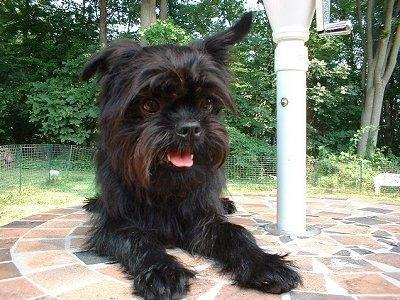

In [65]:
if image:
    # Do something with the image, e.g., display it
    image.show()

In [67]:
width, height = image.size
print(width, height)

400 300


### List dog breeds in the training folder.

In [43]:
folder_prefix = "dogImages/train/"
bucket_name = 'course4-project'

In [44]:
s3_client = boto3.client('s3')
response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=folder_prefix)

In [45]:
if 'Contents' in response:
    for content in response['Contents']:
        print(content['Key'])

dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00005.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00006.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00007.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00008.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00009.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00010.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00011.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00012.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00013.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00014.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00015.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00016.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00017.jpg
dogImages/train/001.Affenpinscher/Affenpinscher_00018.jpg
dogImages/trai

In [60]:
!aws s3 ls s3://course4-project/dogImages/train/ | wc -l

133


**The number of dog breeds is 133.**

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#TODO: Declare your HP ranges, metrics etc.

In [ ]:
#TODO: Create estimators for your HPs

estimator = # TODO: Your estimator here

tuner = # TODO: Your HP tuner here

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit() # TODO: Remember to include your data channels

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

estimator = # TODO: Your estimator here

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()